# Lab 3: Stochastic Gradient Descent

The goal of this lab session is to code an optimization algorithm that optimzes the penalized loss function of the logistic regression model.

You have to send the filled notebook named **"L3_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com by October 17, 2019. Please put **"AML-L3"** in the subject. 

We begin with the standard imports:

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

We import the dataset that we are going to use, an indian dataset including in the last column information about the diabetes status of patients:

In [21]:
from sklearn import model_selection

diabetes_data = pd.read_csv("diabetes_data.csv", sep=",")

avg = np.mean(diabetes_data.iloc[:, :-1].values)
std = np.mean(diabetes_data.iloc[:, :-1].values)

diabetes_train, diabetes_test = model_selection.train_test_split(diabetes_data)
diabetes_train_x = diabetes_train.iloc[:, :-1].values
diabetes_train_y = diabetes_train.iloc[:, -1].values
diabetes_train_y[diabetes_train_y == 0] = -1

diabetes_test_x = diabetes_test.iloc[:, :-1].values
diabetes_test_y = diabetes_test.iloc[:, -1].values
diabetes_test_y[diabetes_test_y == 0] = -1

In [22]:
diabetes_train_x = (diabetes_train_x - avg)/std
diabetes_test_x = (diabetes_test_x - avg)/std

## Logistic Regression



Today we’ll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$F(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


We first use the `sklearn` implementation:

In [23]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="l2", C=2) 
model.fit(diabetes_train_x, diabetes_train_y)
y_pred = model.predict(diabetes_test_x)

C:\Users\sbran\Anaconda3\envs\aml-tp3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


and we compute the accuracy score to evaluate the model performance:

In [24]:
from sklearn.metrics import accuracy_score
accuracy_score(diabetes_test_y, y_pred)

0.796875

Given that the classes balance is :

In [25]:
stats = np.unique(diabetes_test_y,return_counts=True)
for index in range(len(stats[0])):
    print("Class {0} is represented by {1:.1f}% of the data.".format(stats[0][index],
                                                                     stats[1][index]*100/np.sum(stats[1])))

Class -1 is represented by 66.7% of the data.
Class 1 is represented by 33.3% of the data.


### Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent optimization. 

- Fill in the class

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

The gradient of F is :

$$\nabla F(\textbf{w}) = \sum_{i=1}^n \frac{-y_i*\textbf{x}_i}{1+\exp(-y_i\textbf{w}^T\textbf{x}_i)}+\lambda*\textbf{w},$$

Where $\lambda$ is the regularization of the model : it prevents the model from overfitting the data by imposing low values of the model's coefficients.

We can also write F using a decomposition $$F(\textbf{w})=\sum_{i=1}^n f_i(\textbf{w})$$ with $$f_i(\textbf{w})=log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2*n} \| \textbf{w} \|^2,$$

In [76]:
class StochasticLogisticRegression():
    """ Class for logistic regression:
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients 
    alpha_: float
        regularization parameter
    lr_: float
        the learning rate
    bsize: integer
        the size of the mini-batch >=1
    coef_history_: list
        the list of all visited betas
    f_history_: list 
        the list of all evaluations in visited betas
    """
    def __init__(self, reg, lr=1e-3, grad_avg=False, batch_size=50, max_iter=500, tol=1e-6):
        self.coef_  = None
        self.tol_ = tol
        self.reg_ = reg
        self.max_iter_ = max_iter
        self.has_converged_ = False
        
        
        self.grad_avg_ = grad_avg
        self.lr_ = lr
        self.batch_size_ = batch_size
        
        self.grad_sum_ = 0
        self.coef_history_ = []
        self.f_history_ = []

    def logistic(self, z):
        # logistic function
        return 1/(1+np.exp(-z)) 
    
    def gradient(self, coef, batch, X, y, itr, grad_avg=False):
        n = X.shape[0]
        grad = 0
        
        for sample_idx in batch:
            y_i = y[sample_idx]
            x_i = X[sample_idx]
            exp = np.exp(-y_i * np.matmul(np.transpose(coef), x_i))
            grad += - y_i * x_i * exp / (1 + exp) + self.reg_*coef / n
            
        if grad_avg:
            grad += self.grad_sum_
            self.grad_sum_ = grad
            grad /= itr
        
        return grad
    
    def loss(self, coef, X, y):
        F = 0
        for i in range(X.shape[0]):
            F += np.log(1 + np.exp(-y[i]*np.matmul(np.transpose(X[i]), coef)))

        return F + self.reg_ * 0.5 * np.matmul(np.transpose(coef), coef)

    def fit(self, X, y, start):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        
        self.coef_ = start
        self.coef_history_.append(self.coef_)
        self.f_history_.append(self.loss(coef=self.coef_, X=X, y=y))
        
        # Batches creation
        batches = []
        indexes = list(range(X.shape[0]))
        while len(indexes) > 0:
            batch = []
            while len(batch) < self.batch_size_ and len(indexes) > 0:
                i = np.random.randint(low=0,high=len(indexes),size=1)[0]
                batch.append(indexes.pop(i))
            batches.append(batch)
            
            
        itr = 0
        while itr < self.max_iter_ and not self.has_converged_: # critere de convergence
            itr += 1
            lr = max(self.lr_ / itr, 1e-3)
            coef_np1 = self.coef_ - lr * self.gradient(coef=self.coef_, 
                                                       X=X, y=y, 
                                                       itr=itr, 
                                                       grad_avg=self.grad_avg_, 
                                                       batch=batches[itr%len(batches)])

            fn = self.f_history_[-1]
            fnp1 = self.loss(X=X, y=y, coef=coef_np1)
            
            if (fn - fnp1)/fnp1 <= self.tol_:
                self.has_converged_ = True
            # Update the memory
            self.coef_ = coef_np1
            self.coef_history_.append(self.coef_)
            self.f_history_.append(fnp1)
            
         
    def predict(self, X):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (0 or 1)
        """
        y_pred = self.logistic(np.matmul(X, self.coef_)) > 0.5
        y_pred = y_pred.astype(int) # y_pred = 0 or 1 according to the probability
        y_pred = y_pred*2 - 1 # the classes are -1 or 1
        
        return y_pred

In [77]:
class StochasticAverageLogisticRegression():
    """ Class for logistic regression:
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients 
    alpha_: float
        regularization parameter
    lr_: float
        the learning rate
    bsize: integer
        the size of the mini-batch >=1
    coef_history_: list
        the list of all visited betas
    f_history_: list 
        the list of all evaluations in visited betas
    """
    def __init__(self, reg, lr=1e-3, grad_avg=False, batch_size=50, max_iter=500, tol=1e-6):
        self.coef_  = None
        self.tol_ = tol
        self.reg_ = reg
        self.max_iter_ = max_iter
        self.has_converged_ = False
        
        
        self.grad_avg_ = grad_avg
        self.lr_ = lr
        self.batch_size_ = batch_size
        
        self.grad_sum_ = 0
        self.coef_history_ = []
        self.f_history_ = []

    def logistic(self, z):
        # logistic function
        return 1/(1+np.exp(-z)) 
    
    def gradient(self, coef, batch, X, y, itr, grad_avg=False):
        n = X.shape[0]
        grad = 0
        
        for sample_idx in batch:
            y_i = y[sample_idx]
            x_i = X[sample_idx]
            exp = np.exp(-y_i * np.matmul(np.transpose(coef), x_i))
            grad += - y_i * x_i * exp / (1 + exp) + self.reg_*coef / n
            
        if grad_avg:
            grad += self.grad_sum_
            self.grad_sum_ = grad
            grad /= itr
        
        return grad
    
    def loss(self, coef, X, y):
        F = 0
        for i in range(X.shape[0]):
            F += np.log(1 + np.exp(-y[i]*np.matmul(np.transpose(X[i]), coef)))

        return F + self.reg_ * 0.5 * np.matmul(np.transpose(coef), coef)

    def fit(self, X, y, start):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        
        self.coef_ = start
        self.coef_history_.append(self.coef_)
        self.f_history_.append(self.loss(coef=self.coef_, X=X, y=y))
        
        # Batches creation
        batches = []
        indexes = list(range(X.shape[0]))
        while len(indexes) > 0:
            batch = []
            while len(batch) < self.batch_size_ and len(indexes) > 0:
                i = np.random.randint(low=0,high=len(indexes),size=1)[0]
                batch.append(indexes.pop(i))
            batches.append(batch)
            
            
        itr = 0
        while itr < self.max_iter_ and not self.has_converged_: # critere de convergence
            itr += 1
            lr = max(self.lr_ / itr**0.75, 1e-4)
            coef_np1 = self.coef_ - lr * self.gradient(coef=self.coef_, 
                                                       X=X, y=y, 
                                                       itr=itr, 
                                                       grad_avg=self.grad_avg_, 
                                                       batch=batches[itr%len(batches)])

            coef_np1 = (1 - 1/itr)*self.coef_history_[-1] + coef_np1 / itr
            fn = self.f_history_[-1]
            fnp1 = self.loss(X=X, y=y, coef=coef_np1)
            
            if (fn - fnp1)/fnp1 <= self.tol_:
                self.has_converged_ = True
            # Update the memory
            self.coef_ = coef_np1
            self.coef_history_.append(self.coef_)
            self.f_history_.append(fnp1)
            
         
    def predict(self, X):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (0 or 1)
        """
        y_pred = self.logistic(np.matmul(X, self.coef_)) > 0.5
        y_pred = y_pred.astype(int) # y_pred = 0 or 1 according to the probability
        y_pred = y_pred*2 - 1 # the classes are -1 or 1
        
        return y_pred

**Warning** : The maximu value for the stepsize $\theta$ is $$(\frac{1}{4}*\sum_{i=1}^n \| \textbf{x}_i \|^2+\lambda)^{-1}$$

In [78]:
def stepsize_max(alpha):
    stepsize_max = 0
    for index in range(len(diabetes_train_x)):
        stepsize_max += np.matmul(np.transpose(diabetes_train_x[index]),diabetes_train_x[index])
    stepsize_max = 1/(stepsize_max/4 + alpha)
    
    return stepsize_max

for alpha in [10, 1, 1e-1, 1e-2, 1e-3]:
    print("The maximum value of the stepsize for alpha={0} the stepsize is : {1}".format(alpha,stepsize_max(alpha)))

The maximum value of the stepsize for alpha=10 the stepsize is : 0.0005171730265124121
The maximum value of the stepsize for alpha=1 the stepsize is : 0.0005195914948659615
The maximum value of the stepsize for alpha=0.1 the stepsize is : 0.0005198345863327776
The maximum value of the stepsize for alpha=0.01 the stepsize is : 0.0005198589079904125
The maximum value of the stepsize for alpha=0.001 the stepsize is : 0.0005198613402813504


Apply to the data

### Without averaging

Batch size: 1 Iterations: 3
Batch size: 10 Iterations: 2
Batch size: 25 Iterations: 29
Batch size: 50 Iterations: 12
Batch size: 100 Iterations: 12
Batch size: 250 Iterations: 124


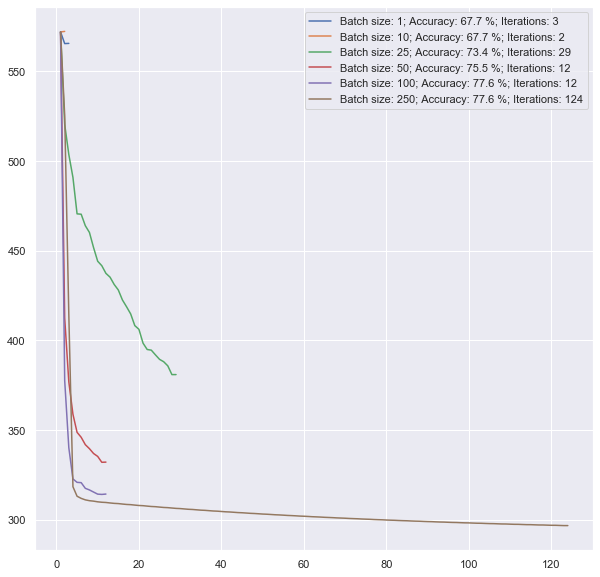

In [79]:
from sklearn.metrics import accuracy_score

plt.figure(figsize=(10,10))

for batch_size in [1,10,25,50,100,250]:
    my_model = StochasticLogisticRegression(reg=1, lr=0.01, batch_size=batch_size, max_iter=2000, tol=1e-6) 
    my_model.fit(diabetes_train_x, diabetes_train_y, start=np.ones(shape=(diabetes_train_x.shape[1])))
    y_pred = my_model.predict(diabetes_test_x)
    plt.plot([i for i in range(1,len(my_model.f_history_)+1)], 
             my_model.f_history_, 
             label="Batch size: {}; Accuracy: {:.1f} %; Iterations: {}".format(batch_size,
                                                                              accuracy_score(diabetes_test_y, y_pred)*100,
                                                                              len(my_model.f_history_)))
    plt.legend()
    print("Batch size:", batch_size, "Iterations:", len(my_model.f_history_))
plt.show()

### With averaging

In [ ]:
from sklearn.metrics import accuracy_score

plt.figure(figsize=(10,10))

for batch_size in [1,10,25,50,100,250]:
    my_model = StochasticAverageLogisticRegression(reg=1, lr=0.001, batch_size=batch_size, max_iter=5000, tol=1e-6) 
    my_model.fit(diabetes_train_x, diabetes_train_y, start=np.ones(shape=(diabetes_train_x.shape[1])))
    y_pred = my_model.predict(diabetes_test_x)
    plt.plot([i for i in range(1,len(my_model.f_history_)+1)], 
             my_model.f_history_, 
             label="Batch size: {}; Accuracy: {:.1f} %; Iterations: {}".format(batch_size,
                                                                              accuracy_score(diabetes_test_y, y_pred)*100,
                                                                              len(my_model.f_history_)))
    plt.legend()
    print("Batch size:", batch_size, "Iterations:", len(my_model.f_history_))
plt.show()

and we compute the accuracy score to evaluate the model performance:

In [63]:
from sklearn.metrics import confusion_matrix
y_pred = my_model.predict(diabetes_test_x)
#print(my_model.coef_)
print(accuracy_score(diabetes_test_y, y_pred))
print(confusion_matrix(diabetes_test_y, y_pred))

0.7760416666666666
[[118  10]
 [ 33  31]]


Let's plot the evolution of our loss function

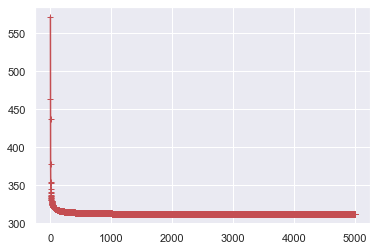

In [64]:
plt.plot([i for i in range(1,len(my_model.f_history_)+1)], my_model.f_history_, marker='+', color='r')

Comment the results

Implement only one acceleration method and compare the results